<a href="https://colab.research.google.com/github/Catairu/AIML_project/blob/main/Progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎧 Spotify Million Playlist Dataset Challenge

The **Spotify Million Playlist Dataset (MPD)** is a large-scale dataset created to support research in music recommendation systems. It was introduced as part of the **RecSys Challenge 2018**, which took place from January to July 2018.

This dataset contains **1,000,000 user-generated playlists**, collected from the Spotify platform between **January 2010 and October 2017**. Each playlist includes metadata such as:
- Playlist titles
- Track titles
- Track URIs and other contextual information

---
The main task is to develop systems for **automatic playlist continuation**  




# 📥 Importing Required Libraries



In [41]:
import os
import json
import torch
from zipfile import ZipFile

import gc

from tqdm import tqdm

import gdown

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, defaultdict
import itertools
from itertools import product


from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance
from scipy.special import expit
from sklearn.decomposition import TruncatedSVD


# 📦 Dataset Download


In [42]:
FOLDER_PATH: str = "/content/Data/MPD.zip"
FOLDER_ID: str = "1iPEPBSF9Ce-6rHWRwqZtAZy9ebeVkn_Z"


if not (os.path.exists(FOLDER_PATH) | os.path.exists("/content/data")):
   gdown.download_folder(f"https://drive.google.com/drive/folders/{FOLDER_ID}",
                         output="Data", quiet=False)
if not os.path.exists("/content/data"):
  with ZipFile(FOLDER_PATH, 'r') as zip:
      files_to_extract: list[str] = [f for f in zip.namelist() if f.startswith("data/")]
      for file in tqdm(files_to_extract, desc='Extracting files'):
          zip.extract(member=file, path="/content/")

!rm -rf /content/Data

# 📊 EDA
Each file in the dataset contains 1,000 playlists, with an average of 66.35 tracks per playlist. For every track, we also have detailed metadata, which includes:

    Artist: The performer or group associated with the track.

    Artist_uri: Uniform Resource Identifier

    Album: The album or collection the track belongs to.

    Album_uri: Uniform Resource Identifier

    Track Name: The title of the track.

    Track_uri: Uniform Resource Identifier
    
    Track Duration: The length of the track in seconds or minutes.
In total, the dataset encompasses 1,000,000 playlists.
As a first step, I will conduct an exploratory analysis on a single file, 0_999.json. After completing the processing of the entire dataset, I will extend the exploratory analysis to the full collection to identify broader trends and patterns.


In [ ]:
with open("/content/data/mpd.slice.0-999.json", 'r') as f:
    single_file = json.load(f)

single_file['playlists'][0]['tracks'][0]

{'pos': 0,
 'artist_name': 'Missy Elliott',
 'track_uri': 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI',
 'artist_uri': 'spotify:artist:2wIVse2owClT7go1WT98tk',
 'track_name': 'Lose Control (feat. Ciara & Fat Man Scoop)',
 'album_uri': 'spotify:album:6vV5UrXcfyQD1wu4Qo2I9K',
 'duration_ms': 226863,
 'album_name': 'The Cookbook'}

# Top artists and tracks
To handle the issue of ambiguity, especially with track names that could be duplicated, I first created a mapping between URIs and names. Without this mapping, I would have faced significant problems with name collisions, particularly for tracks."

In [ ]:
uri_to_artist = {track['artist_uri']: track['artist_name'] for p in single_file['playlists'] for track in p['tracks']}
all_artists = [track["artist_uri"] for p in single_file["playlists"] for track in p["tracks"]]
artists_count = Counter(all_artists)

uri_to_track = {track['track_uri']: track['track_name'] for p in single_file['playlists'] for track in p['tracks']}
all_tracks = [track["track_uri"] for p in single_file["playlists"] for track in p["tracks"]]
tracks_count = Counter(all_tracks)

top_tracks = pd.DataFrame(tracks_count.most_common(10), columns=["Track", "Count"])
top_tracks["Track"] = top_tracks["Track"].map(uri_to_track)
top_artists = pd.DataFrame(artists_count.most_common(10), columns=["Artist", "Count"])
top_artists["Artist"] = top_artists["Artist"].map(uri_to_artist)
print(pd.concat([top_tracks, top_artists], axis=1))

                         Track  Count          Artist  Count
0                    One Dance     55           Drake    938
1                      HUMBLE.     52      Kanye West    415
2  Broccoli (feat. Lil Yachty)     50  Kendrick Lamar    385
3                       Closer     46         Rihanna    350
4              Congratulations     44          Eminem    332
5            Don't Let Me Down     42      The Weeknd    296
6      iSpy (feat. Lil Yachty)     39    Lil Uzi Vert    292
7                        Roses     39      Ed Sheeran    285
8                      Jumpman     39          Future    264
9                  Bounce Back     39     Chris Brown    259


# Playlist and Track duration

Upon analyzing this file, we can clearly identify the presence of a 40-minute track which, in reality, appears to be an entire DJ set. It is highly unlikely that such content is commonly included in user-generated playlists. Therefore, it would be appropriate to exclude it from the dataset to avoid skewing the analysis.

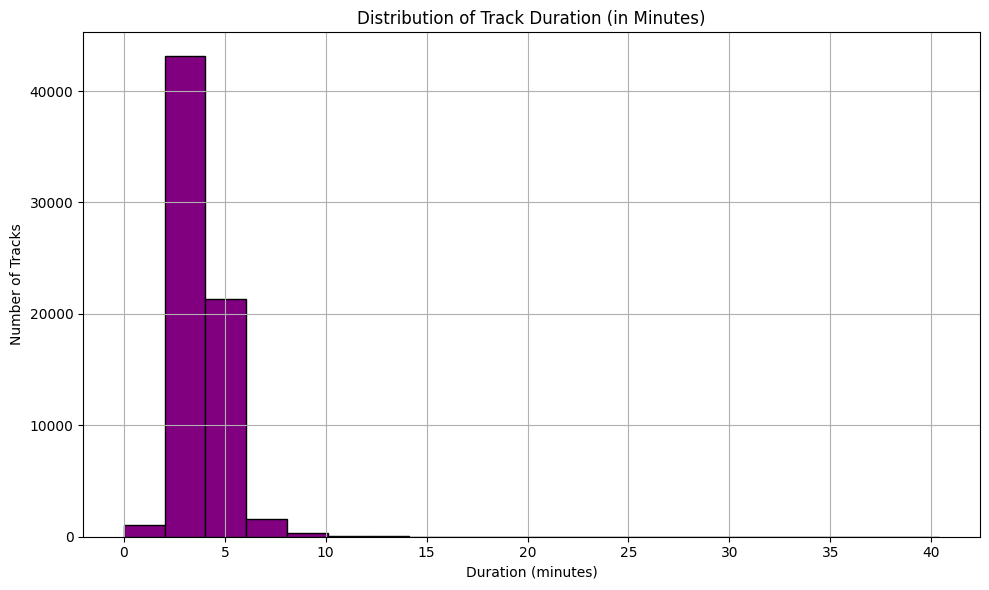

In [ ]:
track_duration = [(track["track_uri"], track["duration_ms"]) for p in single_file["playlists"] for track in p["tracks"]]
track_duration_minutes = [d[1] / 60000 for d in track_duration]

plt.figure(figsize=(10, 6))
plt.hist(track_duration_minutes, bins=20, color='purple', edgecolor='black')
plt.title('Distribution of Track Duration (in Minutes)')
plt.xlabel('Duration (minutes)')
plt.ylabel('Number of Tracks')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print([(i,j) for i, j in enumerate(track_duration_minutes) if j > 40])

[(58418, 40.40315)]


In [ ]:
track_duration[58418]

('spotify:track:2AqUDNyeBEd0qnWnGB9b9k', 2424189)

In [ ]:
playlist_durations_ms = [
    sum(track["duration_ms"] for track in p["tracks"])
    for p in single_file["playlists"]
]

playlist_durations_minutes = [d / 60000 for d in playlist_durations_ms]

average_duration_per_playlist = sum(playlist_durations_minutes) / len(playlist_durations_minutes)
print(f"Durata media per playlist: {average_duration_per_playlist:.2f} minuti")


Durata media per playlist: 262.34 minuti


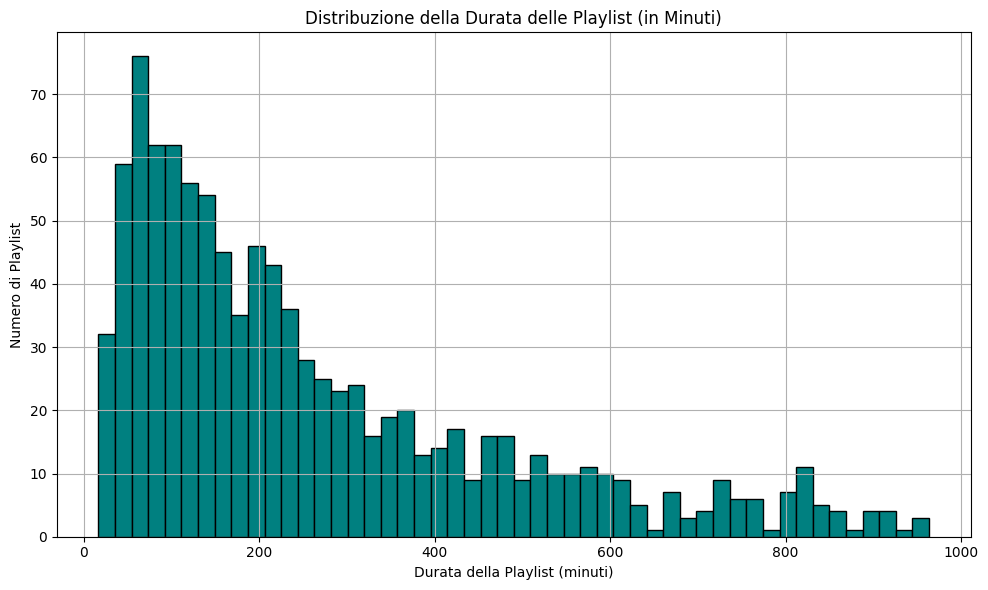

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(playlist_durations_minutes, bins=50, color='teal', edgecolor='black')
plt.title('Distribuzione della Durata delle Playlist (in Minuti)')
plt.xlabel('Durata della Playlist (minuti)')
plt.ylabel('Numero di Playlist')
plt.grid(True)
plt.tight_layout()
plt.show()

# Num_tracks Distribution: Identifying and Handling Outliers
I wanted to check the distribution of the number of tracks per playlist to identify any outliers. My goal was to see if discarding these outliers would improve the results or cause me to lose valuable information.\

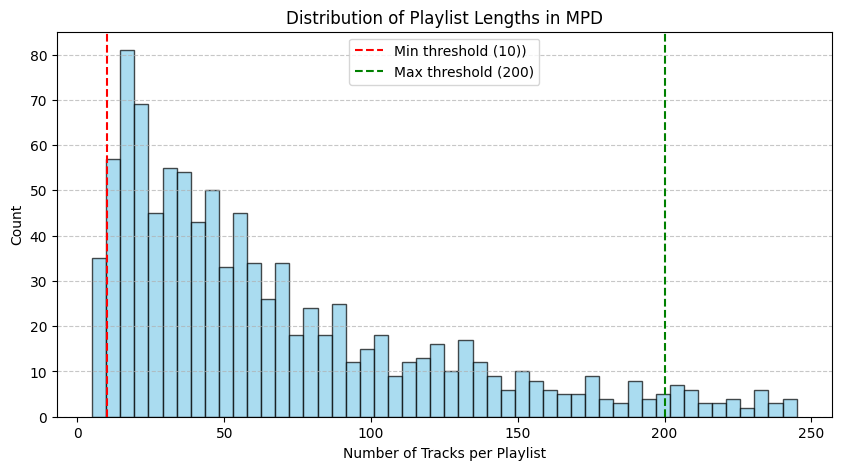

Min number of tracks: 5
Max number of tracks: 245
Average number of tracks: 67.50


In [ ]:
num_tracks = np.array([p["num_tracks"] for p in single_file["playlists"]])

min_threshold = 10
max_threshold = 200

plt.figure(figsize=(10, 5))
plt.hist(num_tracks, bins=50, color="skyblue", edgecolor="black", alpha=0.7)

plt.axvline(x=min_threshold, color="red", linestyle="dashed", label=f"Min threshold ({min_threshold}))")
plt.axvline(x=max_threshold, color="green", linestyle="dashed", label=f"Max threshold ({max_threshold})")

plt.xlabel("Number of Tracks per Playlist")
plt.ylabel("Count")
plt.title("Distribution of Playlist Lengths in MPD")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

min_tracks = np.min(num_tracks)
max_tracks = np.max(num_tracks)
avg_tracks = np.mean(num_tracks)

print(f"Min number of tracks: {min_tracks}")
print(f"Max number of tracks: {max_tracks}")
print(f"Average number of tracks: {avg_tracks:.2f}")

In [ ]:
num_total = len(num_tracks)
num_in_range = np.sum((num_tracks >= min_threshold) & (num_tracks <= max_threshold))
percentage = (num_in_range / num_total) * 100

print(f"{percentage:.2f}% of playlists have between {min_threshold} and {max_threshold} tracks.")


92.70% of playlists have between 10 and 200 tracks.


In [ ]:
df_playlists = pd.DataFrame(single_file["playlists"], columns = ['pid', 'num_followers'])
print(df_playlists.sort_values(by="num_followers", ascending=False))

     pid  num_followers
765  765           1038
255  255             22
241  241             18
539  539             17
365  365             15
..   ...            ...
21    21              1
23    23              1
24    24              1
26    26              1
27    27              1

[1000 rows x 2 columns]


# Similarity Check
I used Jaccard similarity to measure how similar two playlists are, with the goal of identifying and potentially removing playlists that are too similar to each other. Highly similar playlists may contain redundant information, which could be unnecessary or even harmful during the training phase.

Jaccard similarity is defined as the size of the intersection divided by the size of the union of two sets—in this case, the sets of tracks in each playlist.
$$
\text{Jaccard}(A, B) = \frac{|A \cap B|}{|A \cup B|}
$$

Top 1: Playlist 325 and Playlist 292 with similarity 0.3654
Top 2: Playlist 325 and Playlist 834 with similarity 0.3333
Top 3: Playlist 765 and Playlist 748 with similarity 0.3016
Top 4: Playlist 748 and Playlist 292 with similarity 0.2708
Top 5: Playlist 765 and Playlist 292 with similarity 0.2688
Top 6: Playlist 27 and Playlist 213 with similarity 0.2609
Top 7: Playlist 293 and Playlist 842 with similarity 0.2468
Top 8: Playlist 765 and Playlist 325 with similarity 0.2418
Top 9: Playlist 803 and Playlist 412 with similarity 0.2342
Top 10: Playlist 325 and Playlist 748 with similarity 0.2316


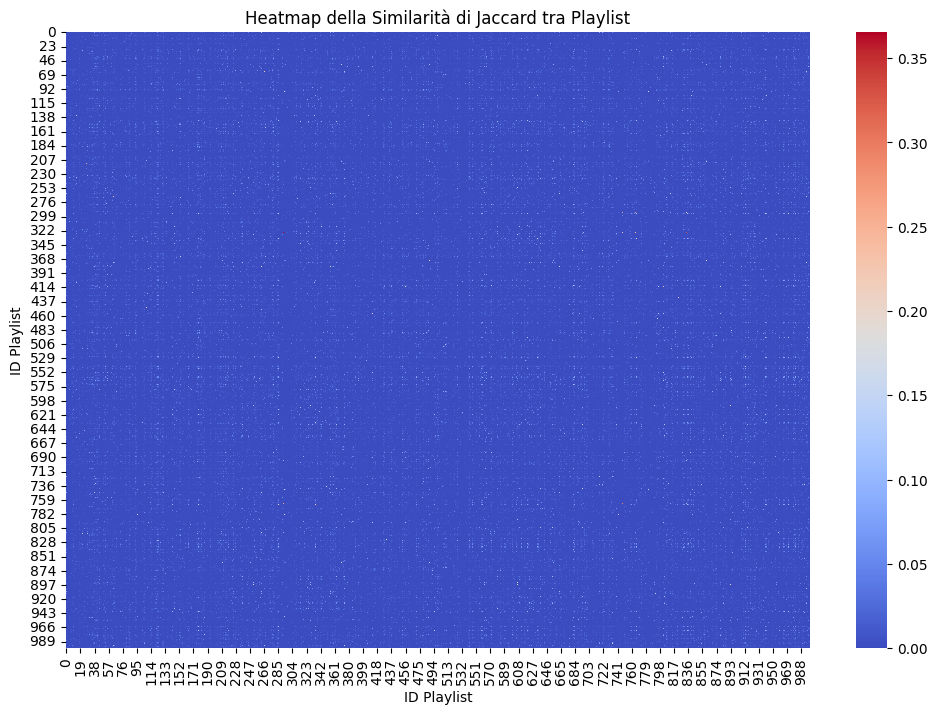

In [ ]:
def sparse_jaccard_similarity(X):
    intersection = X @ X.T
    row_sums = X.sum(axis=1).A1
    unions = row_sums[:, None] + row_sums[None, :] - intersection.toarray()
    similarity = intersection.toarray() / unions
    np.fill_diagonal(similarity, 0)
    return similarity


uri_to_number = {uri: idx for idx, uri in enumerate(uri_to_track)}

binary_matrix = np.zeros((len(single_file["playlists"]), len(uri_to_track)))
for i, playlist in enumerate(single_file["playlists"]):
    for track in playlist["tracks"]:
        binary_matrix[i, uri_to_number[track['track_uri']]] = 1

binary_sparse = csr_matrix(binary_matrix)

similarity_matrix = sparse_jaccard_similarity(binary_sparse)

flat = similarity_matrix.flatten()
top_10_indices = np.argsort(flat)[-20:][::-2]

top_10_pairs = [np.unravel_index(idx, similarity_matrix.shape) for idx in top_10_indices]

for idx, (i, j) in enumerate(top_10_pairs):
      print(f"Top {idx+1}: Playlist {i} and Playlist {j} with similarity {similarity_matrix[i, j]:.4f}")

plt.figure(figsize=(12, 8))
sns.heatmap(similarity_matrix, cmap="coolwarm", cbar=True)
plt.title("Heatmap della Similarità di Jaccard tra Playlist")
plt.xlabel("ID Playlist")
plt.ylabel("ID Playlist")
plt.show()


#🔍 Data Preprocessing and Train-Test Split

In [ ]:
def process_track(track, playlist_id):
    track_id = track_ids.setdefault(track['track_uri'], len(track_ids))
    artist_id = artist_ids.setdefault(track['artist_name'], len(artist_ids))
    if track_id == len(tracks_metadata):
      tracks_metadata.append((track_id, track['track_name'], artist_id, track['artist_name']))
    return (playlist_id, track_ids[track['track_uri']], 1)

train_data = []
test_data = []
track_ids = dict()
artist_ids = dict()
playlists_metadata = []
tracks_metadata = []
files_to_extract = sorted([f"/content/data/{f}" for f in os.listdir("/content/data")], key=lambda x : int(x.split('.')[2].split('-')[0]))
for file in tqdm(files_to_extract, desc="Processing files"):
    with open(file, 'r') as f:
        data = json.load(f)
    for playlist in data['playlists']:
      playlist_id = playlist['pid']
      playlists_metadata.append(( playlist_id, playlist['num_tracks'], playlist['num_followers']))
      tracks_data = [process_track(track, playlist_id) for track in  playlist['tracks']]
      np.random.shuffle(tracks_data)
      splitting_point = int(playlist['num_tracks']*0.8)
      train_data.extend(tracks_data[:splitting_point])
      test_data.extend(tracks_data[splitting_point:])


train_df = pd.DataFrame(train_data, columns=['playlist_id', 'track_id', 'presence']).astype({'playlist_id': 'uint32', 'track_id': 'uint32', 'presence': 'uint8'})
test_df = pd.DataFrame(test_data, columns=['playlist_id', 'track_id', 'presence']).astype({'playlist_id': 'uint32', 'track_id': 'uint32', 'presence': 'uint8'})
playlists_metadata_df = pd.DataFrame(playlists_metadata, columns=['playlist_id', 'num_tracks', 'num_followers']).astype({'playlist_id': 'uint32', 'num_tracks': 'uint16', 'num_followers': 'uint32'})
tracks_metadata_df = pd.DataFrame(tracks_metadata, columns=['track_id', 'track_name', 'artist_id', 'artist_name']).astype({'track_id': 'uint32', 'track_name': 'category', 'artist_id' : 'uint32', 'artist_name': 'category'})


Processing files: 100%|██████████| 1000/1000 [10:25<00:00,  1.60it/s]


# Free RAM and Memory usage
Here, I am clearing all global variables except for a selected set, which includes imported libraries and the four key DataFrames (train_df, test_df, playlists_metadata_df, and tracks_metadata_df) that are needed for further analysis and model training.

In [ ]:
keep_vars = {
    'train_df', 'test_df', 'playlists_metadata_df', 'tracks_metadata_df',
    'pd', 'np','tqdm', 'gc',
    'plt', 'sns',
    'Counter', 'defaultdict',
    'distance', 'itertools',
    'csr_matrix', 'TruncatedSVD',
    'torch', 'pdist', 'squareform',
    'expit', 'product'
}

for var in list(globals().keys()):
    if var not in keep_vars and not var.startswith("_"):
        del globals()[var]

gc.collect()


0

In [ ]:
train_df.memory_usage(deep=True)

,0
Index,132
playlist_id,210717988
track_id,210717988
presence,52679497


In [ ]:
test_df.memory_usage(deep=True)

,0
Index,132
playlist_id,54667724
track_id,54667724
presence,13666931


In [ ]:
playlists_metadata_df.memory_usage(deep=True)

,0
Index,132
playlist_id,4000000
num_tracks,2000000
num_followers,4000000


In [ ]:
tracks_metadata_df.memory_usage(deep=True)

,0
Index,132
track_id,9049168
track_name,168644773
artist_id,9049168
artist_name,38280970


# 📊 EDA

I am repeating the same steps as before, this time applied to the whole dataset.

In [ ]:
track_name_map = tracks_metadata_df.set_index('track_id')['track_name'].to_dict()
track_artist_id = tracks_metadata_df.set_index('track_id')['artist_id'].to_dict()
artist_name_map = tracks_metadata_df.set_index('artist_id')['artist_name'].to_dict()

all_tracks_ids = train_df['track_id'].tolist()
all_artists_ids = train_df['track_id'].map(track_artist_id).tolist()

artist_counts = Counter(all_artists_ids)
track_counts = Counter(all_tracks_ids)

top_tracks_df = (
    pd.DataFrame(track_counts.items(), columns=["track_id", "track_count"])
      .sort_values(by="track_count", ascending=False)
)

top_tracks_df["track_name"] = top_tracks_df["track_id"].map(track_name_map)
top_tracks = top_tracks_df["track_id"].tolist()
top_artists_df = (
    pd.DataFrame(artist_counts.items(), columns=["artist_id", "artist_count"])
      .sort_values(by="artist_count", ascending=False)
)

top_artists_df["artist_name"] = top_artists_df["artist_id"].map(artist_name_map)

top_tracks_10 = top_tracks_df.head(10).reset_index(drop=True)
top_artists_10 = top_artists_df.head(10).reset_index(drop=True)

top_combined = pd.concat([top_tracks_10, top_artists_10], axis=1)

top_combined

,track_id,track_count,track_name,artist_id,artist_count,artist_name
0,1335,37066,HUMBLE.,344,672937,Drake
1,3713,34409,One Dance,431,328327,Kanye West
2,1396,32752,Broccoli (feat. Lil Yachty),357,281179,Kendrick Lamar
3,1874,32513,Closer,205,269841,Rihanna
4,2715,31647,Congratulations,412,251411,The Weeknd
5,2701,27898,Caroline,831,233715,Eminem
6,2698,27846,Bad and Boujee (feat. Lil Uzi Vert),212,215931,Ed Sheeran
7,1333,27770,iSpy (feat. Lil Yachty),823,199155,Future
8,1159,27593,XO TOUR Llif3,28,193111,Justin Bieber
9,3545,27426,Location,352,191939,J. Cole


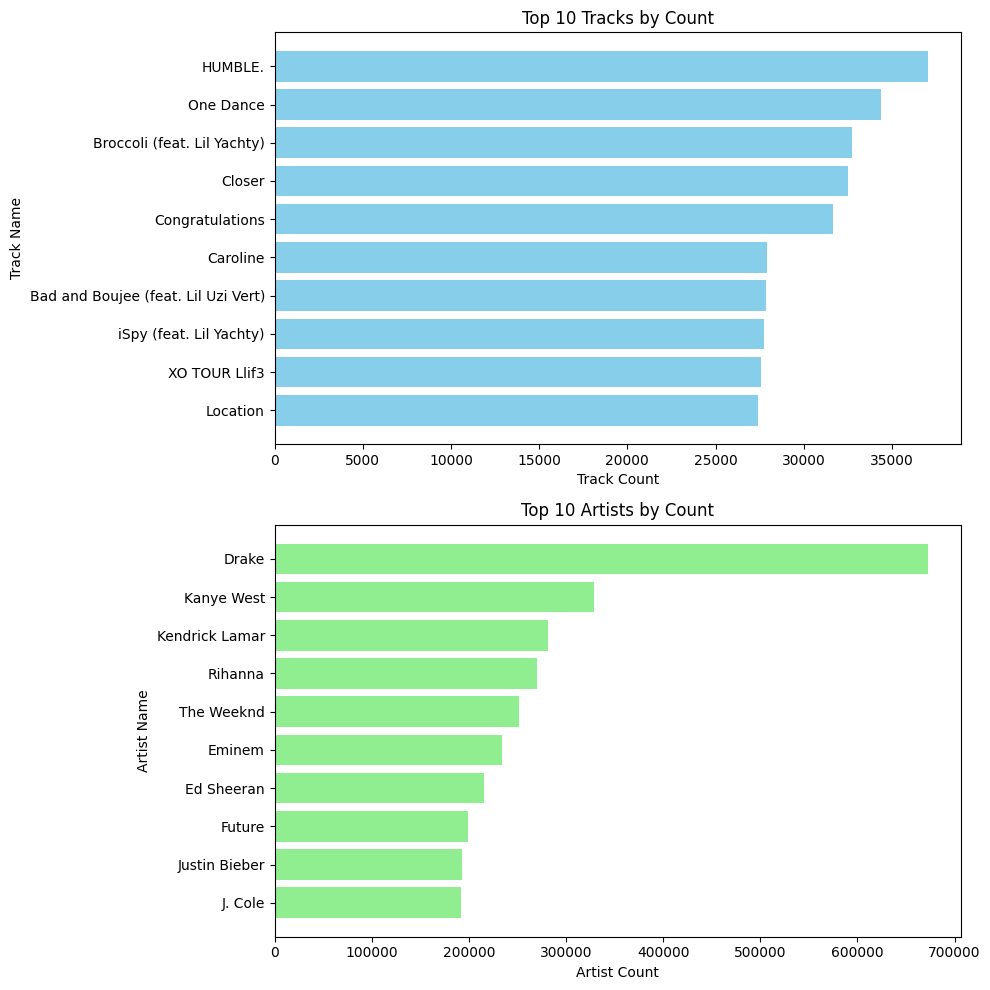

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

axes[0].barh(top_tracks_10['track_name'], top_tracks_10['track_count'], color='skyblue')
axes[0].set_xlabel('Track Count')
axes[0].set_ylabel('Track Name')
axes[0].set_title('Top 10 Tracks by Count')
axes[0].invert_yaxis()

axes[1].barh(top_artists_10['artist_name'], top_artists_10['artist_count'], color='lightgreen')
axes[1].set_xlabel('Artist Count')
axes[1].set_ylabel('Artist Name')
axes[1].set_title('Top 10 Artists by Count')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


In [ ]:
train_df['artist_id'] = train_df['track_id'].map(track_artist_id)
num_unique_artists =train_df.groupby('playlist_id')['artist_id'].nunique()
num_unique_tracks = train_df.groupby('playlist_id')['track_id'].nunique()
artist_diversity = num_unique_artists / num_unique_tracks
train_df = train_df.drop(columns=['artist_id'])

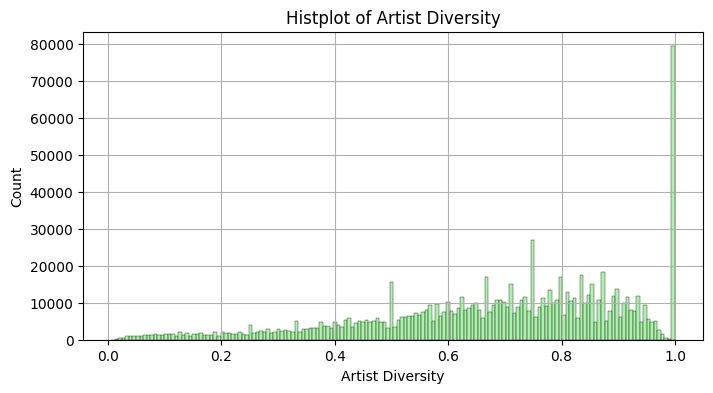

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(x=artist_diversity, color='lightgreen')
plt.title('Histplot of Artist Diversity')
plt.xlabel('Artist Diversity')
plt.grid(True)
plt.show()

In [ ]:
del artist_diversity, num_unique_artists, num_unique_tracks
gc.collect()

86

# Tracks and artists popularity normalized
The idea here is to obtain numerical values based on the counts of various tracks and artists, which reflect the popularity of a track or artist. This information will then be leveraged during the evaluation phase to adjust and enhance the predicted track IDs generated by SVD the model.
Although this approach can be a good solution to improve recommendation quality by favoring more popular items, it is not guaranteed to always be effective. In certain cases, it could introduce bias toward popular tracks, potentially reducing the model's ability to recommend more diverse or niche content.

In [ ]:
artist_pop = {}
for track_id in top_tracks:
    artist_id = tracks_metadata_df.loc[track_id, 'artist_id']
    artist_pop[track_id] = artist_counts[artist_id]

tracks_min, tracks_max = min(track_counts.values()), max(track_counts.values())
artist_min, artist_max = min(artist_pop.values()), max(artist_pop.values())

tracks_pop_norm = {track_id: (count - tracks_min) / tracks_max for track_id, count in track_counts.items()}
artists_pop_norm = {artist_id: (count - artist_min) / artist_max for artist_id, count in artist_pop.items()}

In [ ]:
num_tracks = np.max(top_tracks) + 1

track_vec = torch.zeros(num_tracks, dtype=torch.float32)
for track_id, score in tracks_pop_norm.items():
        track_vec[track_id] = score

artist_vec = torch.zeros(num_tracks, dtype=torch.float32)
for track_id, score in artists_pop_norm.items():
        artist_vec[track_id] = score

track_vec_gpu = torch.tensor(track_vec, dtype=torch.float32).cuda()
artist_vec_gpu = torch.tensor(artist_vec, dtype=torch.float32).cuda()

<ipython-input-26-feccbfef7ee5>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  track_vec_gpu = torch.tensor(track_vec, dtype=torch.float32).cuda()
<ipython-input-26-feccbfef7ee5>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  artist_vec_gpu = torch.tensor(artist_vec, dtype=torch.float32).cuda()


# Num_tracks Distribution: Identifying and Handling Outliers


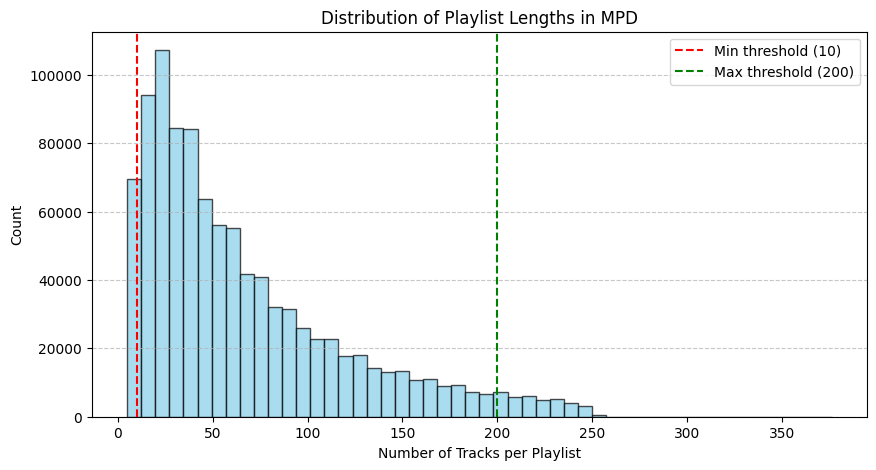

Min number of tracks: 5
Max number of tracks: 376
Average number of tracks: 66.35


In [ ]:
num_tracks_arr = np.array(playlists_metadata_df['num_tracks'])

min_threshold = 10
max_threshold = 200

plt.figure(figsize=(10, 5))
plt.hist(num_tracks_arr, bins=50, color="skyblue", edgecolor="black", alpha=0.7)

plt.axvline(x=min_threshold, color="red", linestyle="dashed", label=f"Min threshold ({min_threshold})")
plt.axvline(x=max_threshold, color="green", linestyle="dashed", label=f"Max threshold ({max_threshold})")

plt.xlabel("Number of Tracks per Playlist")
plt.ylabel("Count")
plt.title("Distribution of Playlist Lengths in MPD")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

min_tracks = np.min(num_tracks_arr)
max_tracks = np.max(num_tracks_arr)
avg_tracks = np.mean(num_tracks_arr)

print(f"Min number of tracks: {min_tracks}")
print(f"Max number of tracks: {max_tracks}")
print(f"Average number of tracks: {avg_tracks:.2f}")

In [ ]:
num_total = len(num_tracks_arr)
num_in_range = (num_tracks_arr >= min_threshold) & (num_tracks_arr <= max_threshold)
percentage = (np.sum(num_in_range) / num_total) * 100

print(f"{percentage:.2f}% of playlists have between {min_threshold} and {max_threshold} tracks.")


93.01% of playlists have between 10 and 200 tracks.


# Incorporating Playlist Popularity into Track Weighting for Improved Recommendation Modeling
Considering that each playlist had a different number of followers — which can be interpreted as an indicator of the audience's appreciation for the tracks it contains — I chose to modify the standard collaborative filtering approach.
Instead of constructing a playlist ID × track ID matrix with binary values (1 for presence and 0 for absence), I assigned different weights to the track entries based on the popularity of the playlists they appeared in.
This method allows tracks from highly followed playlists to have greater influence during model training, while ensuring that tracks from less popular playlists are still fairly represented, thus avoiding an excessive imbalance.

In [ ]:
print(playlists_metadata_df.sort_values(by="num_followers", ascending=False).head())

        playlist_id  num_tracks  num_followers
248269       248269          39          71643
746359       746359         106          53519
399472       399472         111          45942
180831       180831          85          31539
720740       720740          81          27830


In [ ]:
num_tracks = np.max(top_tracks) + 1
num_playlists = test_df["playlist_id"].max() +1

log_weights = np.log2(playlists_metadata_df["num_followers"]+1)
playlists_metadata_df["weight"] = expit(log_weights)
train_df = train_df.merge(playlists_metadata_df[["playlist_id", "weight"]], on="playlist_id", how="left")
train_df["weighted_presence"] = train_df["presence"] * train_df["weight"]
train_df = train_df.drop(columns=["weight"])



In [ ]:
print(playlists_metadata_df.sort_values(by="weight", ascending=True))

        playlist_id  num_tracks  num_followers    weight
619898       619898          79              1  0.731059
619882       619882          51              1  0.731059
619883       619883          46              1  0.731059
619884       619884         171              1  0.731059
619886       619886         232              1  0.731059
...             ...         ...            ...       ...
720740       720740          81          27830  1.000000
180831       180831          85          31539  1.000000
399472       399472         111          45942  1.000000
746359       746359         106          53519  1.000000
248269       248269          39          71643  1.000000

[1000000 rows x 4 columns]


I am converting the dataframe into a sparse matrix to improve memory efficiency. Additionally, I create train_grouped and test_grouped, which are used for evaluation as they map each playlist ID to its corresponding track IDs.

In [ ]:
train_sparse = csr_matrix(
    (train_df["weighted_presence"].astype(np.float32), (train_df["playlist_id"], train_df["track_id"])),
    shape=(num_playlists, num_tracks)
)
train_grouped = train_df.groupby('playlist_id')['track_id'].apply(lambda x: np.array(x, dtype=np.uint32))
test_grouped = test_df.groupby('playlist_id')['track_id'].apply(lambda x: np.array(x, dtype=np.uint32))

In [ ]:
train_sparse.nnz


52115029

In [ ]:
sparsity = 1.0 - (train_sparse.nnz / (train_sparse.shape[0] * train_sparse.shape[1]))
print(f"Sparsity of the playlist-track matrix: {sparsity:.8f}")

Sparsity of the playlist-track matrix: 0.99997696


In [ ]:
keep_vars = {
    'test_grouped', 'train_grouped', 'train_sparse', 'track_vec_gpu',
    'artist_vec_gpu','top_tracks', 'num_playlists',
    'pd', 'np','tqdm', 'gc',
    'TruncatedSVD', 'torch',
    'itertools', 'product'
}

for var in list(globals().keys()):
    if var not in keep_vars and not var.startswith("_"):
        del globals()[var]

gc.collect()


0

# 🛠️ Model Training and Evaluation

In [ ]:
n_components = 250
svd = TruncatedSVD(n_components = n_components)
train_svd = svd.fit_transform(train_sparse).astype(np.float32)
V_gpu = torch.tensor(svd.components_.T , dtype=torch.float32).cuda()
train_svd_gpu = torch.tensor(train_svd, dtype=torch.float32).cuda()

# Baseline
As a baseline, I implemented a popularity-based recommendation method. I selected the top tracks based on their frequency of occurrence in the playlists from the training set and evaluated the recommendations by checking whether any of these tracks matched those in the test set. Naturally, tracks that were already present in the specific playlist's training data were excluded from the evaluation. Given the computational cost of calculating metrics for all 1,000,000 playlists, I chose to evaluate the model on a random sample of num_eval playlists, typically with num_eval ≤ 10,000.

In [ ]:
num_eval = 100000
test_pids = np.random.choice(np.arange(num_playlists), size=num_eval, replace=False)
Ks = [5, 10, 15, 20]
K_max = max(Ks)

precision_scores = np.zeros((num_eval, len(Ks)), dtype=np.float32)
recall_scores = np.zeros((num_eval, len(Ks)), dtype=np.float32)
rr_scores = np.zeros(num_eval, dtype=np.float32)

top_tracks_ = top_tracks[:3000]

for i, pid in enumerate(tqdm(test_pids, desc='Playlist done:')):
    ground_truth = test_grouped.get(pid)
    already_seen = train_grouped.get(pid)
    G = len(ground_truth)

    unseen = [tid for tid in top_tracks_ if tid not in already_seen]
    recommended = unseen[:K_max]

    for j, K in enumerate(Ks):
        current_K = min(K, G)
        recs_k = recommended[:current_K]
        hits = [tid for tid in recs_k if tid in ground_truth]
        H = len(hits)

        precision_scores[i, j] = H / K
        recall_scores[i, j] = H / G

    rr = 0.0
    for idx, tid in enumerate(recommended,1):
        if tid in ground_truth:
          rr = 1.0 / idx
          break

    rr_scores[i] = rr

results = []
for j, K in enumerate(Ks):
    results.append({
        "K": K,
        "Precision@K": precision_scores[:, j].mean(),
        "Recall@K": recall_scores[:, j].mean(),
    })

baseline_results = pd.DataFrame(results).set_index("K")

print(f"\nMRR: {rr_scores.mean()}")
print(baseline_results)

Playlist done:: 100%|██████████| 100000/100000 [20:06<00:00, 82.89it/s]



MRR: 0.028457045555114746
    Precision@K  Recall@K
K                        
5      0.011132  0.004067
10     0.008782  0.005881
15     0.007445  0.006932
20     0.006267  0.007411


#  SVD_Evaluation
As mentioned earlier, I have a variable num_eval, which is used to perform a search for the optimal weights. This search aims to create a recommendation system by combining SVD factors with artist and track popularity in a randomized manner, ensuring that the sum of the weights is always equal to 1. I leverage the GPU to accelerate the computations. Once the optimal weights have been identified, I use them for the final evaluation, employing a larger num_eval and a higher value of K_MRR.

In [ ]:
num_eval = 10000
test_pids = np.random.choice(np.arange(num_playlists), size=num_eval, replace=False)

K_mrr = 250

Ks = [5, 10, 15, 20]
K_max = max(Ks)

weight_combinations = [(1,0,0)]
svd_weights = [0.9, 0.95]
combination_per_weight = 4

for w in svd_weights:
  for i in range(combination_per_weight):
    remaining = 1 - w
    track_w = np.random.uniform(0, remaining)
    artist_w = remaining - track_w
    weight_combinations.append((w, track_w, artist_w))


all_results = []

for weights in tqdm(weight_combinations, desc="Weight combinations"):
    svd_w, track_w, artist_w = weights

    precision_scores = np.zeros((num_eval, len(Ks)), dtype=np.float32)
    recall_scores = np.zeros((num_eval, len(Ks)), dtype=np.float32)
    rr_scores = np.zeros(num_eval, dtype=np.float32)

    for i, pid in enumerate(test_pids):
        ground_truth = test_grouped.get(pid)
        already_seen = train_grouped.get(pid)
        G = len(ground_truth)

        svd_scores = torch.matmul(V_gpu, train_svd_gpu[pid])

        final_scores = (
            svd_w * svd_scores +
            track_w * track_vec_gpu +
            artist_w * artist_vec_gpu
        )

        seen_idx = torch.tensor(list(already_seen), dtype=torch.long, device=final_scores.device)
        final_scores[seen_idx] = -float('inf')
        top_scores, top_indices = torch.topk(final_scores, K_mrr)
        recommended = top_indices.cpu().numpy()

        for j, K in enumerate(Ks):
            current_K = min(K, G)
            recs_k = recommended[:current_K]
            hits = [tid for tid in recs_k if tid in ground_truth]
            H = len(hits)
            precision_scores[i, j] = H / current_K
            recall_scores[i, j] = H / G

        rr = 0.0
        for idx, tid in enumerate(recommended, 1):
            if tid in ground_truth:
                rr = 1.0 / idx
                break
        rr_scores[i] = rr

    avg_precision = precision_scores.mean(axis=0)
    avg_recall = recall_scores.mean(axis=0)
    avg_mrr = rr_scores.mean()

    all_results.append({
        "weights": weights,
        "MRR": avg_mrr,
        "Precision@10": avg_precision[Ks.index(10)],
        "Recall@10": avg_recall[Ks.index(10)],
        "Precision@20": avg_precision[Ks.index(20)],
        "Recall@20": avg_recall[Ks.index(20)],
    })

results_df = pd.DataFrame(all_results)
results_df = results_df.set_index("weights").sort_values(by="MRR", ascending=False)
results_df

Weight combinations: 100%|██████████| 9/9 [16:09<00:00, 107.69s/it]


,MRR,Precision@10,Recall@10,Precision@20,Recall@20
weights,,,,,
"(1, 0, 0)",0.275830,0.107408,0.069134,0.094437,0.083056
"(0.95, 0.03706490805745762, 0.012935091942542422)",0.272803,0.106779,0.068586,0.093500,0.082189
"(0.95, 0.03899495371567267, 0.011005046284327372)",0.272797,0.106868,0.068657,0.093515,0.082208
"(0.95, 0.018992220211659423, 0.03100777978834062)",0.270785,0.106203,0.068073,0.093128,0.081786
"(0.95, 0.010551453689417187, 0.03944854631058286)",0.269838,0.105788,0.067811,0.093025,0.081670
"(0.9, 0.08720597754181382, 0.012794022458186158)",0.267339,0.104528,0.066513,0.090932,0.079703
"(0.9, 0.09683264228754206, 0.0031673577124579216)",0.266698,0.104324,0.066364,0.090628,0.079415
"(0.9, 0.062331422149180526, 0.03766857785081945)",0.266260,0.104229,0.066317,0.090980,0.079712
"(0.9, 0.006477328584710594, 0.09352267141528939)",0.251536,0.098700,0.061649,0.085606,0.074487


In [ ]:
num_eval = 100000
best_weights = results_df.index[0]
svd_w, track_w, artist_w = best_weights


test_pids = np.random.choice(np.arange(num_playlists), size=num_eval, replace=False)


K_mrr = 500

precision_scores = np.zeros((num_eval, len(Ks)), dtype=np.float32)
recall_scores = np.zeros((num_eval, len(Ks)), dtype=np.float32)
rr_scores = np.zeros(num_eval, dtype=np.float32)

for i, pid in enumerate(tqdm(test_pids, desc='Playlist done:')):
    ground_truth = test_grouped.get(pid)
    already_seen = train_grouped.get(pid)
    G = len(ground_truth)

    svd_scores = torch.matmul(V_gpu, train_svd_gpu[pid])
    final_scores = (
        svd_w * svd_scores +
        track_w * track_vec_gpu +
        artist_w * artist_vec_gpu
)
    seen_idx = torch.tensor(list(already_seen), dtype=torch.long, device=final_scores.device)
    final_scores[seen_idx] = -float('inf')
    top_scores, top_indices = torch.topk(final_scores, K_mrr)
    recommended = top_indices.cpu().numpy()

    for j, K in enumerate(Ks):

      current_K = min(K, G)

      recs_k = recommended[:current_K]

      hits = [tid for tid in recs_k if tid in ground_truth]
      H = len(hits)

      precision_scores[i, j] = H / current_K
      recall_scores[i, j] = H / G

    rr = 0.0
    for idx, tid in enumerate(recommended,1):
        if tid in ground_truth:
          rr = 1.0 / idx
          break

    rr_scores[i] = rr

results = []
for j, K in enumerate(Ks):
    results.append({
        "K": K,
        "Precision@K": precision_scores[:, j].mean(),
        "Recall@K": recall_scores[:, j].mean(),
    })

svd_results_df = pd.DataFrame(results).set_index("K")

print(f"\n svd_score: {svd_w}, track_score: {track_w}, artist_score: {artist_w}, \
 n_components: {n_components}, n_eval: {num_eval}, K_mrr: {K_mrr}")
print(f"\n MRR: {rr_scores.mean()}")
print(svd_results_df)

Playlist done:: 100%|██████████| 100000/100000 [18:13<00:00, 91.46it/s]


 svd_score: 1, track_score: 0, artist_score: 0,  n_components: 250, n_eval: 100000, K_mrr: 500

 MRR: 0.2827876806259155
    Precision@K  Recall@K
K                        
5      0.128112  0.050651
10     0.107169  0.069434
15     0.098484  0.078335
20     0.094084  0.083072


# Final Report

## Overview

The task addressed in this project is a music recommendation problem, specifically aimed at predicting missing tracks in user-generated playlists. Given the nature of the problem, both collaborative filtering and content-based approaches were considered.

## Data Processing

The dataset was preprocessed into four primary DataFrames:

   * Train/Test Splits: For each playlist, a train-test split was performed at 80% of its length. Playlists were shuffled prior to splitting to eliminate any bias due to track order.

   * Playlist Metadata: Containing information such as num_tracks, number of followers, etc.

   * Track Metadata: Including artist names and other available features.

Working with one million playlists posed a significant memory challenge. To manage this:

  * All data types were explicitly optimized (e.g., uint8 for binary matrices).

  * The main interaction matrix was stored in sparse format, which drastically reduced memory usage.

  * During training and experimentation, global variables were carefully managed, and garbage collection was invoked as needed to free memory.



## Modeling Approach
1. Collaborative Filtering with Truncated SVD

The initial model employed Truncated SVD on the playlist-track matrix, a  binary matrix indicating the presence (1) or absence (0) of a track in a playlist. This method projects playlists and tracks into a shared latent space, where recommendations are made based on similarity in this lower-dimensional space.

The key hyperparameter, n_components, determines the number of latent features. While increasing it typically improves performance, it also increases memory usage. After empirical testing, the optimal setting was found to be 250 components, balancing performance with system stability.

2. Weighted Presence Based on Playlist Popularity

To improve upon the basic SVD model, I introduced a weighting scheme based on playlist popularity. The hypothesis was that tracks in playlists with more followers are likely to be of higher quality or broader appeal. To this end, each playlist's track presence values were scaled by the logarithm of its follower count. This modification led to a slight but consistent improvement in recommendation quality.

3. Hybrid Model with Popularity Scores

To incorporate content-based signals without relying on external APIs, I experimented with track and artist popularity scores, based on their frequency across the dataset. These scores were linearly combined with the SVD outputs in a hybrid model, using grid search to optimize their respective weights. Surprisingly, the best-performing configuration always favored 100% SVD, suggesting that collaborative signals dominated the available information and the popularity scores contributed minimally.

Nevertheless, the popularity-based model served as a useful baseline, providing a straightforward non-personalized benchmark.

## Limitations and Future Work

One major constraint of the project was the prohibition of Spotify API usage. With access to the API, I could have enriched the model with audio features (tempo, valence, danceability, etc.) and genre information—both of which are highly predictive in music recommendation contexts. Genre tags, in particular, could have helped cluster similar tracks and improve recommendations, especially for cold-start playlists.

Another promising direction would be the incorporation of track order and proximity information. Although the order of tracks was discarded in the current model, there's substantial evidence that adjacency of tracks in playlists often reflects meaningful relationships (e.g., mood transitions, thematic similarity). A potential enhancement would be to build a track-to-track proximity matrix, giving higher scores to tracks that frequently appear near each other in playlists. This could then be combined with the SVD-based latent representations to create a more powerful hybrid model.

Additionally, leveraging neural architectures (e.g., sequence models like RNNs or Transformers) could allow the model to learn complex sequential patterns and contextual dependencies between tracks.

## Evaluation and Results

Recommendations were evaluated using standard metrics such as Precision@K, Recall@K, and MRR (Mean Reciprocal Rank). As expected:

  * Precision tends to decrease as K increases, due to a larger candidate set.

  * Recall tends to increase with K, as the chance of recovering a relevant track improves.

  * The SVD model significantly outperformed the popularity baseline across all metrics, often by a factor of 10x or more.

These results confirm that collaborative signals encoded in user-generated playlists are highly informative for the recommendation task.
